# Build binary classification models where some use RFE selected features

In [11]:
import model.load_data as ld
import scoring_metrics as sm

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
import matplotlib
from sklearn.model_selection import train_test_split 
pd.set_option('display.max_columns', None)

In [17]:
datasets = """Bed002 Bed003 Bed004 Bed005 Bed006 Bed008 Bed009 Bed010 Bed011 Bed012 Bed013 Bed014 Bed015 Bed016 Bed017 Bmr001 Bmr002 Bmr005 Bmr007 Bmr009 Bmr010 Bmr011 Bmr012 Bmr013 Bmr014 Bmr018 Bmr019 Bmr021 Bmr022 Bmr024 Bmr025 Bmr026 Bmr027 Bmr029 Bns001 Bns002""".split(" ")
results_merged_path = "../results_merged_fixedf0/"

X_train_20, X_test_20, y_train_20, y_test_20 = ld.train_test_split(datasets,results_merged_path,0.2)
X_train_40, X_test_40, y_train_40, y_test_40 = ld.train_test_split(datasets,results_merged_path,0.2)

print(X_train_20)

   pause  speakerChange      similarity  f0_diff  f0_baseline_diff
0  0.534            1.0  [[0.78211725]]      0.0           0.00000
1 -0.892            1.0  [[0.78211725]]      0.0           0.00000
2  0.500            0.0  [[0.66966593]]      0.0           0.00000
3 -0.373            1.0  [[0.66966593]]      0.0           0.16123
4  0.387            1.0  [[0.96409994]]      0.0           0.00000


In [13]:
# # First part is merging all meetings
# datasets = "Bed002 Bed003 Bed004 Bed005 Bed006 Bed008 Bed009 Bed010 Bed011 Bed012 Bed013 Bed014 Bed015 Bed016 Bed017 Bmr001 Bmr002 Bmr005 Bmr007 Bmr009 Bmr010 Bmr011 Bmr012 Bmr013 Bmr014 Bmr018 Bmr019 Bmr021 Bmr022 Bmr024 Bmr025 Bmr026 Bmr027 Bmr029 Bns001 Bns002".split(" ")
# meetings_to_test = "Bed002".split(" ")
# results_merged_path = "../results_merged/"

# all_df = pd.DataFrame()
# for elem in meetings_to_test:
#     path = (os.path.realpath(os.path.join(os.getcwd(), (f"{results_merged_path}"+ elem + ".csv"))))
#     df = pd.read_csv(path, sep=';')
#     all_df = pd.concat([all_df,df], ignore_index=True)
    
# #change boolean to 1 or 0
# all_df['speakerChange'] = all_df["speakerChange"].astype(float)
# all_df['boundary'] = all_df["boundary"].astype(float)

# #replace nan by zero
# all_df.fillna(0,inplace=True)

# #keep only useful columns (can't use f0_means, f0_stds, and similarity yet as they are lists)
# #test using the same amount of rows with boundary==1 and ==0
# # nbr_1 = len(all_df.loc[all_df['boundary']==1])
# # df_0 = all_df.loc[all_df['boundary']==0].head(nbr_1)
# # df_1 = all_df.loc[all_df['boundary']==1]
# # df_balanced = pd.concat([df_0,df_1], ignore_index=True)
# # df_balanced.reset_index(drop=True,inplace=True)
# # X_df = df_balanced[['StartTimeA','EndTimeA','StartTimeB','EndTimeB','pause','speakerChange']]
# # y_df = df_balanced['boundary']

# #normal split (but WARNING!!! NBR OF BOUNDARY == 1 IS VERYYYY LOW)
# X_df = all_df[['StartTimeA','EndTimeA','StartTimeB','EndTimeB','pause','speakerChange']]
# y_df = all_df['boundary']

# #check dataset statistics
# print(y_df.describe())
# print(X_df.corrwith(y_df))

# #split dataset
# X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_df, y_df, test_size = 0.20, random_state = 97,stratify=y_df)
# X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(X_df, y_df, test_size = 0.40, random_state = 97,stratify=y_df)

## Test on commonly used models

### XGB Classifier for binary class

In [14]:
def XGB_class(X_train, X_test, y_train, y_test):
    
    clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False)
    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)
    
    return clf.predict_proba(X_test)[:,1]

In [15]:
XGBc_y_predicted_20 = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20)
# print(sm.get_windiff(np.array(y_test_20),np.array(X_test_20),10))

XGBc_y_predicted_40 = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40)

C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


TypeError: '<' not supported between instances of 'float' and 'str'

### SVM for binary class

In [ ]:
def SVMc(X_train,X_test,y_train,y_test):
    clf = SVC(kernel='linear',probability=True) 
    clf.fit(X_train, y_train) 
    preds = clf.predict(X_test)
    sSVM_y_predicted = clf.predict_proba(X_test)[:,1]
    
    return sSVM_y_predicted

In [ ]:
# print('Using 20% as test subset:')
# SVM_y_predicted_20 = SVMc(X_train_20,X_test_20,y_train_20,y_test_20)
# print('Using 40% as test subset:')
# SVM_y_predicted_40 = SVMc(X_train_40,X_test_40,y_train_40,y_test_40)

### Random Forest classifier for binary class

In [ ]:
def RFc(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    preds = model.predict(X_test)
    sRFC_y_predicted = model.predict_proba(X_test)[:,1]
    
    return sRFC_y_predicted

In [ ]:
print('Using 20% as test subset:')
RFc_y_predicted_20 = RFc(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
RFc_y_predicted_40 = RFc(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
Using 40% as test subset:


### Logistic Regressor for binary class

In [ ]:
def LR(X_train,X_test,y_train,y_test):
    model = LogisticRegression(random_state=0).fit(X_train,y_train)
    preds = model.predict(X_test)
    sLR_y_predicted = model.predict_proba(X_test)[:,1]
    
    return sLR_y_predicted

In [ ]:
print('Using 20% as test subset:')
LR_y_predicted_20 = LR(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% as test subset:')
LR_y_predicted_40 = LR(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% as test subset:
Using 40% as test subset:


C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\marti\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

### Plot AUC-ROC Curve

In [ ]:
def roc(y_tests,y_predicted,models_name,title):  
    if len(y_predicted)>2:  
        #there are 4 diff colors in max
        colors = ["red", "blue", "green", "orange"]
            
        for i in range(int(len(y_predicted)/2)):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-',color=colors[i])

        counter=0
        for i in range(int(len(y_predicted)/2),int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='--',color=colors[counter])
            counter+=1
    
    else:
        for i in range(int(len(y_predicted))):
            fpr, tpr, _ = metrics.roc_curve(y_tests[i],  y_predicted[i])
            #create ROC curve
            plt.plot(fpr, tpr, linestyle='-')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(models_name)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.show()

C:\Users\marti\AppData\Local\Temp\ipykernel_21176\1674596823.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40])
C:\Users\marti\AppData\Local\Temp\ipykernel_21176\1674596823.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_preds = np.array([XGBc_y_predicted_20,RFc_y_predicted_20,LR_y_predicted_20,XGBc_y_predicted_40,RFc_y_predicted_40,LR_y_predicted_40])


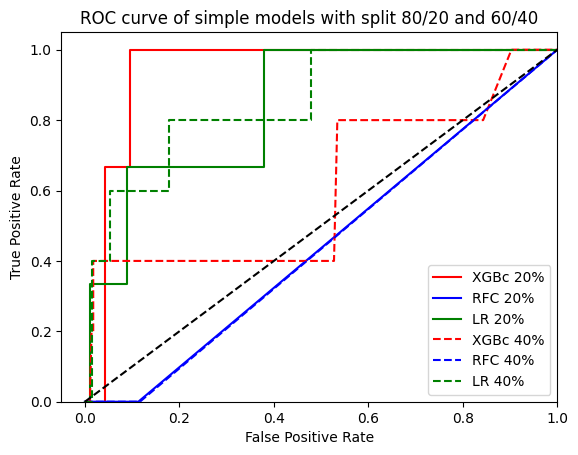

In [ ]:
y_tests = np.array([y_test_20,y_test_20,y_test_20,y_test_40,y_test_40,y_test_40])
y_preds = np.array([XGBc_y_predicted_20,RFc_y_predicted_20,LR_y_predicted_20,XGBc_y_predicted_40,RFc_y_predicted_40,LR_y_predicted_40])
models_name=np.array(['XGBc 20%','RFC 20%','LR 20%','XGBc 40%','RFC 40%','LR 40%'])
title = 'ROC curve of simple models with split 80/20 and 60/40'
roc(y_tests,y_preds,models_name,title)